In [71]:
import os
import pickle
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from src.cf_methods import c3lt 
from src.datasets import DatasetBuilder

from src.models.classifiers import SimpleCNNtorch
from src.evaluation.local_instability import perturb_sample
from src.utils import seed_everything, get_config, load_model_weights
from src.utils import evaluate_classification_model, plot_boxplot
from src.utils import extract_factual_instances, filter_valid_factuals

In [2]:
seed_everything()

In [3]:
import sys
sys.argv = ['']

In [4]:
repo_path = 'D:\PycharmProjects\CF-Robustness-Benchmark' # '/data/leuven/365/vsc36567/CF-Robustness-Benchmark'
config_path = osp.join(repo_path, 'configs/train_classifier_mnist.yaml')

config = get_config(config_path)
config.data_dir = osp.join(repo_path, config.data_dir)
ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders() 
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# Create an args object to pass all relevant parameters 
weights_dir = osp.join(repo_path, 'src/cf_methods/c3lt/weights')
clf_dir = osp.join(repo_path, 'notebooks/experiments/mnist_classification/binary/checkpoints')
log_path = osp.join(repo_path, 'cf_output/mnist/c3lt_binary')

args = c3lt.args.init_parser()
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.log_path = log_path
args.gen_path = osp.join(weights_dir, 'generator_mnist_1_7.pth')
args.disc_path = osp.join(weights_dir, 'discriminator_mnist_1_7.pth')
args.enc_path = osp.join(weights_dir, 'encoder_mnist_1_7.pth')
args.cls_path = osp.join(clf_dir, 'mnist_1_7_epoch=00_val_accuracy=0.99.pth')
args.dataset_path = config.data_dir
args.cls_1 = 0  # 1
args.cls_2 = 1  # 7
args.num_classes = 2
args.classifier_args={**config.classifier.args, 
                    'num_classes': config.data.num_classes,
                    'img_size': config.data.img_size
}
args.ndf=32
args.epochs = 150
# args.cls_type = 'bce'
args.extracted_layers = ['main']
args.output = osp.join(repo_path, 'cf_output/mnist/c3lt_binary/results')
os.makedirs(args.output+'/snaps', exist_ok=True)

In [6]:
dataloaders = c3lt.helper.dataloader_pair(args, ds_builder.train_dataset, is_train=True)
dataloaders_test = c3lt.helper.dataloader_pair(args, ds_builder.test_dataset, is_train=False)

# Training

In [7]:
c3lt.train.train_c3lt(args, [dataloaders, dataloaders_test])

Generator loaded!
Discriminator loaded!
Encoder loaded!
Classifier loaded!

Training Starts...

[Epoch 0/150] [TRAIN Loss: 0.41059]

EVAL [CLS loss: 0.0001]  [PROX loss: 0.0587]  [CYC Loss: 0.1857]  [ADV loss: 0.3769]  [EVAL loss: 0.0249] 
EVAL [COUT: 0.9474]  [Validity: 100.00 %]  [Proximity: 0.1711]

[Epoch 1/150] [TRAIN Loss: 0.02595]
[Epoch 2/150] [TRAIN Loss: 0.02495]
[Epoch 3/150] [TRAIN Loss: 0.02388]
[Epoch 4/150] [TRAIN Loss: 0.02284]


KeyboardInterrupt: 

# Robustness evaluation

In [7]:
from src.cf_methods.c3lt import C3LTModel

In [47]:
expl_model = C3LTModel(args)
expl_model.setup_model(mapper_weights_path=osp.join(args.output, 'snaps', 'map_0_to_1_0.pt'))
baseline_classifier = expl_model.classifier

Classifier loaded!
Generator loaded!
Discriminator loaded!
Encoder loaded!


In [48]:
factuals, labels = extract_factual_instances(test_loader, [args.cls_1])
factuals, labels = filter_valid_factuals(factuals, labels, baseline_classifier, device)

## Local Instability

In [49]:
from src.evaluation.local_instability import calculate_ssim, calculate_sparsity
from src.utils import plot_perturbed_factuals_and_cf
from functools import reduce

In [ ]:
save_dir = osp.join(repo_path, 'cf_output/mnist/c3lt_binary')
n = 100
noise_levels = [0.001, 0.0025, 0.005, 0.0075, 0.01]

In [ ]:
factuals_pert = {}    
indices_pert = {}

for noise_level in noise_levels:
    factuals_pert[noise_level] = perturb_sample(factuals, n_samples=1, noise_magnitude=noise_level)
    pert_sample = torch.Tensor(factuals_pert[noise_level])

    # Check whether perturbed instances lead to the same class prediction
    predictions = torch.argmax(baseline_classifier(pert_sample.to(device)), axis=1).detach().cpu()
    indices = np.where(predictions == labels)[0]
    print(f'Number of valid perturbed factuals for the added noise level {noise_level}: ', indices.shape[0])
    pert_sample = pert_sample[indices] 
    indices_pert[noise_level] = indices

Number of valid perturbed factuals for the added noise level 0.001:  1132
Number of valid perturbed factuals for the added noise level 0.0025:  1132
Number of valid perturbed factuals for the added noise level 0.005:  1132
Number of valid perturbed factuals for the added noise level 0.0075:  1131
Number of valid perturbed factuals for the added noise level 0.01:  1131


In [52]:
final_indices = reduce(np.intersect1d, list(indices_pert.values()))[:n]
factuals = factuals[final_indices] 
labels = labels[final_indices]
factuals_pert = {k : v[final_indices] for k, v in factuals_pert.items()}

Generating counterfactrual explanations and evaluate their  validity  

In [53]:
factuals = factuals.to(device)
cfes = expl_model.get_counterfactuals(factuals)

In [54]:
validity = np.where(torch.argmax(baseline_classifier(cfes), axis=1).detach().cpu() == 1)[0]
validity = validity.shape[0] / cfes.shape[0]
print('Validity of the generated explanations:', validity)

Validity of the generated explanations: 1.0


In [55]:
cfes_pert = {}

for noise_level in noise_levels:
    pert_sample = torch.Tensor(factuals_pert[noise_level]).to(device)
    cfes_pert[noise_level] = expl_model.get_counterfactuals(pert_sample) 

In [56]:
target_class = 1

validity_dict = {}
for noise_level in noise_levels:
    predictions = torch.argmax(baseline_classifier(torch.Tensor(cfes_pert[noise_level])), axis=1).detach().cpu()
    indices = np.where(predictions == target_class)[0]
    validity = indices.shape[0] / predictions.shape[0]
    validity_dict[noise_level] = validity
    print(f'Validity for the added noise level {noise_level}: ',  validity)

with open(osp.join(save_dir, 'mnist_1_7_validity.pkl'), 'wb') as f:
    pickle.dump(validity_dict, f)

Validity for the added noise level 0.001:  1.0
Validity for the added noise level 0.0025:  1.0
Validity for the added noise level 0.005:  1.0
Validity for the added noise level 0.0075:  1.0
Validity for the added noise level 0.01:  1.0


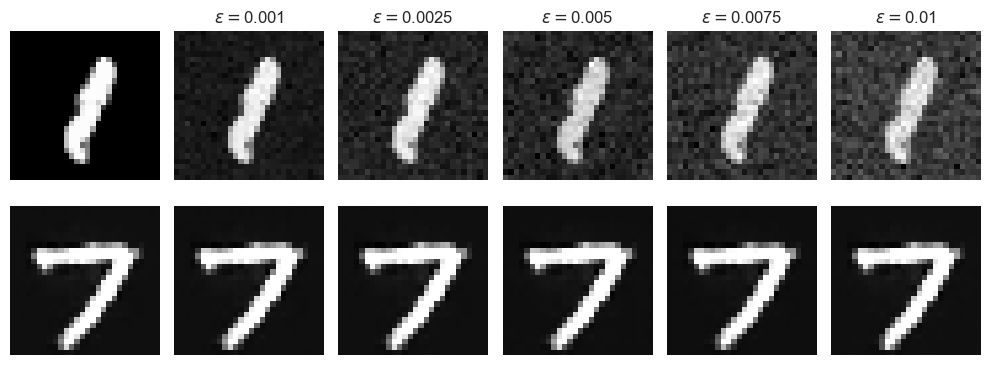

In [57]:
ind = 25
factuals_pert_list = [factuals_pert[noise_level][ind] for noise_level in noise_levels]
cfes_pert_list = [cfes_pert[noise_level][ind] for noise_level in noise_levels]
plot_perturbed_factuals_and_cf(factuals[ind], factuals_pert_list, 
                               cfes[ind], cfes_pert_list,
                               noise_levels)

In [59]:
instability_l1_list = []
ssim_list = []

for noise_level, cfe_pert_list in cfes_pert.items():
    # print('noise level:', noise_level)
    l1_temp = []
    ssim_temp = []
    for i in range(len(cfes)):
        cf = cfes[i].detach().cpu()
        cf_pert = cfe_pert_list[i].detach().cpu()

        if len(cf) == 0:
            continue
        if len(cf_pert) == 0:
            continue

        cf_tensor = torch.Tensor(cf)
        cf = cf_tensor.permute(1, 2, 0).flatten()

        cf_pert_tensor = torch.Tensor(cf_pert)
        cf_perturbed = cf_pert_tensor.permute(1, 2, 0).flatten()        

        l1_distance =  calculate_sparsity(cf, cf_perturbed).item()
        l1_temp.append(l1_distance)

        ssim = calculate_ssim(cf_tensor.unsqueeze(0), cf_pert_tensor.unsqueeze(0)).item()
        ssim_temp.append(ssim)

    instability_l1_list.append(l1_temp)
    ssim_list.append(ssim_temp)
        

# with open(osp.join(save_dir, 'mnist_1_7_li_l1.pkl'), 'wb') as f:
#     pickle.dump(instability_l1_list, f)

# with open(osp.join(save_dir, 'mnsut_1_7_ssim.pkl'), 'wb') as f:
#     pickle.dump(ssim_list, f)

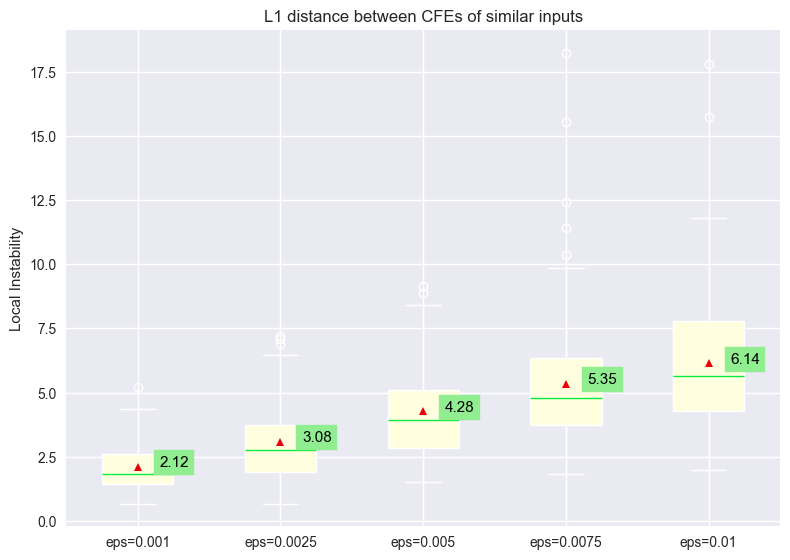

In [63]:
plt.style.use("seaborn-v0_8-bright")


plot_boxplot(data=instability_l1_list, mean_values=np.round(np.mean(instability_l1_list, axis=1), 2),
             tick_labels=[f'eps={noise_level}' for noise_level in noise_levels],
             y_label='Local Instability', colors=['lightyellow'], title='L1 distance between CFEs of similar inputs')

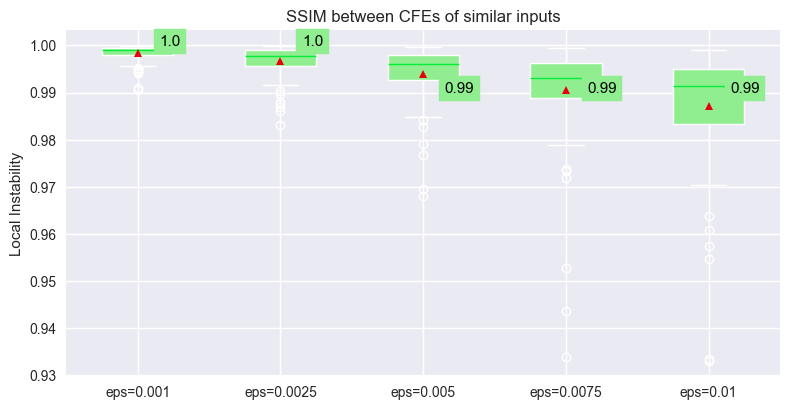

In [64]:
plt.rcParams['figure.figsize'] = [8, 4]

plot_boxplot(data=ssim_list, mean_values=np.round(np.mean(ssim_list, axis=1), 2),
             tick_labels=[f'eps={noise_level}' for noise_level in noise_levels],
             y_label='Local Instability', colors=['lightgreen'], title='SSIM between CFEs of similar inputs')

## Local Lipschitz Continuity

In [30]:
original_points = factuals # factuals_tensor[:n]
original_cfes = cfes
print("Are the lengths of initial points (factuals) and CFEs generated for them equal :", len(original_cfes) == original_points.shape[0])


Are the lengths of initial points (factuals) and CFEs generated for them equal : True


In [ ]:
from tqdm import tqdm


i = 0
lip_estimates = []
noise_magnitude = 0.001

original_points = original_points.detach().cpu()
original_cfes = original_cfes.detach().cpu()
for original_point, original_cfe in tqdm(zip(original_points[:50], original_cfes[:50])):

    neighbor_points = perturb_sample(original_point.unsqueeze(0), n_samples=30, noise_magnitude=noise_magnitude) 
    neighbor_points = torch.Tensor(neighbor_points).to(device)  
    neighbor_cfes = expl_model.get_counterfactuals(neighbor_points).detach().cpu() 
    

    lip_estimate = 0
    for m, p in tqdm(zip(neighbor_cfes, neighbor_points)):
        num = np.linalg.norm((original_cfe - m).flatten(), ord=2) 
        denom = np.linalg.norm((original_point - p).flatten(), ord=2)
        lip = num / denom
        lip_estimate = max(lip, lip_estimate)
 
    lip_estimates.append(lip_estimate.item())
    i += 1

30it [00:00, 20760.46it/s]
30it [00:00, 21432.31it/s]
30it [00:00, 25564.63it/s]
30it [00:00, 26681.32it/s]
30it [00:00, 21254.92it/s]
30it [00:00, 21355.93it/s]
30it [00:00, 26296.58it/s]
30it [00:00, 9171.22it/s]
30it [00:00, 22729.25it/s]
30it [00:00, 26357.17it/s]
30it [00:00, 22223.44it/s]
30it [00:00, 21898.56it/s]
30it [00:00, 22353.73it/s]
30it [00:00, 21998.10it/s]
30it [00:00, 22700.54it/s]
30it [00:00, 22117.97it/s]
30it [00:00, 26143.59it/s]
30it [00:00, 22509.68it/s]
30it [00:00, 22623.00it/s]
30it [00:00, 22558.11it/s]
30it [00:00, 22708.74it/s]
30it [00:00, 23168.68it/s]
30it [00:00, 25960.21it/s]
30it [00:00, 22219.52it/s]
30it [00:00, 22437.43it/s]
30it [00:00, 22353.73it/s]
30it [00:00, 22623.00it/s]
30it [00:00, 22680.09it/s]
30it [00:00, 22778.62it/s]
30it [00:00, 4984.52it/s]
30it [00:00, 22610.80it/s]
30it [00:00, 22725.14it/s]
30it [00:00, 22659.67it/s]
30it [00:00, 22341.82it/s]
30it [00:00, 22795.13it/s]
30it [00:00, 22433.43it/s]
30it [00:00, 26551.83it/s]
30i

In [ ]:
with open(osp.join(save_dir, 'mnist_1_7_lle.pkl'), 'wb') as f:
        pickle.dump(lip_estimates, f)

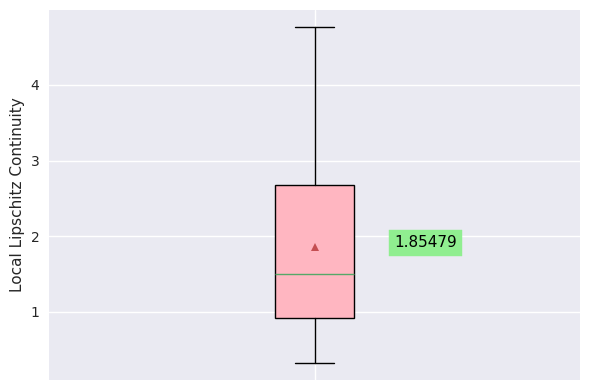

In [ ]:
plt.rcParams['figure.figsize'] = [6, 4]
plot_boxplot(data=lip_estimates, mean_values=[np.round(np.mean(lip_estimates), 5)],
             tick_labels=[''],
             y_label='Local Lipschitz Continuity', colors=['lightpink'], title='')

## Invalidation Rate

In [68]:
classifiers_weights_dir = osp.join(repo_path, r'notebooks/experiments/mnist_classification/binary/checkpoints/mc_1_7')


classifiers_list = []
for clf_weights in os.listdir(classifiers_weights_dir):
    cnn_perturbed = SimpleCNNtorch(**args.classifier_args)
    load_model_weights(model=cnn_perturbed, weights_path=osp.join(classifiers_weights_dir, clf_weights), lightning_used=True)
    classifiers_list.append(cnn_perturbed)
    evaluate_classification_model(cnn_perturbed, dataloader=test_loader, num_classes=config.data.num_classes)

Accuracy for the test dataset: 99.632%
Accuracy for the test dataset: 99.173%
Accuracy for the test dataset: 99.311%
Accuracy for the test dataset: 99.403%
Accuracy for the test dataset: 99.311%
Accuracy for the test dataset: 99.540%
Accuracy for the test dataset: 99.311%
Accuracy for the test dataset: 99.494%
Accuracy for the test dataset: 99.586%
Accuracy for the test dataset: 99.449%


In [ ]:
target_class = 1
validity_list = []
invalidation_rate_list = []

for i, classifier in enumerate(classifiers_list):
    validity = 0
    invalidation_rate = 0
    total_found_cfs = 0
    
    classifier.eval()
    with torch.no_grad():
        classifier = classifier.to(device)

        baseline_pred = torch.argmax(baseline_classifier(cfes), axis=1)
        alternative_pred = torch.argmax(classifier(cfes), axis=1)
    
    invalidation_rate = np.where(baseline_pred.detach().cpu() != alternative_pred.detach().cpu())[0].shape[0] / baseline_pred.shape[0]
    validity = np.where(alternative_pred.detach().cpu() == target_class)[0].shape[0] / alternative_pred.shape[0]

    # invalidation_rate /= total_found_cfs
    invalidation_rate_list.append(invalidation_rate)
    validity_list.append(validity)
    print(f'Model {i}: IR={invalidation_rate}, validity={validity}\n')

print('Average IR : {:.3f} +- {:.3f}'.format(np.mean(invalidation_rate_list), np.std(invalidation_rate_list)))
print('Average VaR : {:.3f} +- {:.3f}'.format(np.mean(validity_list), np.std(validity_list)))

Model 0: IR=0.0, validity=1.0

Model 1: IR=0.0, validity=1.0

Model 2: IR=0.0, validity=1.0

Model 3: IR=0.0, validity=1.0

Model 4: IR=0.0, validity=1.0

Model 5: IR=0.0, validity=1.0

Model 6: IR=0.0, validity=1.0

Model 7: IR=0.0, validity=1.0

Model 8: IR=0.0, validity=1.0

Model 9: IR=0.0, validity=1.0

Average IR : 0.000 +- 0.000
Average VaR : 1.000 +- 0.000


## Stability


In [ ]:
k = 1000
sigma = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

average_stability_list = []
for i, classifier in enumerate(classifiers_list):
    stability_list = []
    for cfe in cfes:

        cfe = torch.Tensor(cfe).unsqueeze(0).detach().cpu()
        cfe_sampled = torch.Tensor(perturb_sample(cfe, n_samples=k, noise_magnitude=sigma))

        with torch.no_grad():
            cf_logits = classifier(cfe.to(device))
            cf_probabilities = F.softmax(cf_logits, dim=-1)[:, target_class]

            cf_sampled_logits = classifier(cfe_sampled.to(device))
            cf_sampled_probabilities = F.softmax(cf_sampled_logits, dim=-1)[:, target_class]
        
        model_variance = abs(cf_probabilities - cf_sampled_probabilities)

        stability = (cf_sampled_probabilities - model_variance).mean()
        stability_list.append(stability.item())

    avg_i_stability = np.mean(stability_list)
    print(f'Stability of the model {i}: {round(avg_i_stability.item(), 3)} +- {round(np.std(stability_list).item(), 2)}')
    average_stability_list.append(avg_i_stability) 

In [45]:
print(f'Average stability over {len(classifiers_list)} models:', np.mean(average_stability_list).round(4))

Average stability over 10 models: 0.6866
